Notebook to reproduce Figure 4.b) of the paper


In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import scipy.integrate as integrate
import scipy.stats as stats
import scipy.optimize as optimize
import tqdm

import sys
sys.path.append('../core')
sys.path.append('..')

from core import erm, gamp
from overlaps import Overlaps, average_overlaps
import core.calibration
import utility
import joint_density
import display as display_

import gcmpyo3

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=10)    # legend fontsize
plt.rc('ytick', labelsize=10)    # legend fontsize
plt.rc('legend', fontsize=10)    # legend fontsize

In [12]:
sigma = 0.5
alphas = np.linspace(0.5, 15, 20)   


### Compute overlaps

In [13]:
class Overlap:
    def __init__(self, m, q, v, mhat, qhat, vhat) -> None:
        self.m = m
        self.q = q
        self.v = v
        self.mhat = mhat
        self.qhat = qhat
        self.vhat = vhat

In [14]:
def compute_overlaps(alphas, lambdas, sigma):
    overlaps = []

    for (a, l) in zip(alphas, lambdas):
        overlaps.append(Overlap(*gcmpyo3.state_evolution.erm_state_evolution_matching(a, sigma**2, l, 1.0, "probit", 1e-4, True, False)))
    return overlaps

In [15]:
p = 0.75
delta_p = 0.025
sigma_0 = 2.0
lambda_ = 1e-32

overlaps_lambda_0 = compute_overlaps(alphas, lambda_ * np.ones(len(alphas)), sigma_0)
overlaps_bo_lambda_0      = [Overlap(*gcmpyo3.state_evolution.bayes_optimal_state_evolution_matching(a, sigma_0**2, 1.0, "probit", lambda_, True, False)) for a in alphas]

In [ ]:
ntrials = 10
ntest = int(10**5)
d = 300

wstar = np.random.normal(0, 1.0, d)
wstar = wstar * np.sqrt(d) / np.linalg.norm(wstar)
xtest = np.random.normal(0, 1.0, (ntest, d)) / np.sqrt(d)
ftest = utility.probit(xtest @ wstar, sigma_0)

exp_alphas = np.linspace(0.5, 15, 30)

teacher_variance = []
bo_variance = []

for alpha in tqdm.tqdm(exp_alphas):
    n = int(alpha * d)
    variance_list = []
    bo_variance_list = []
    for trial in range(ntrials):
        xtrain = np.random.normal(0, 1.0, (n, d)) / np.sqrt(d)
        ytrain = np.sign(xtrain @ wstar + sigma_0 * np.random.normal(0, 1.0, n))
        
        what = erm.erm_logistic_regression(xtrain, ytrain, lambda_)
        fhat = utility.sigmoid(xtest @ what)
        index_p = np.where((fhat > p - delta_p) & (fhat < p + delta_p))[0]
        fteacher = ftest[index_p]
        variance_list.append(np.var(fteacher))

        res_gamp = gamp.iterate_gamp(xtrain, ytrain, wstar, sig = sigma_0, verbose=False)
        wbo, vbo = res_gamp["estimator"], res_gamp["variances"]
        fbo = utility.probit(xtest @ wbo, np.sqrt(sigma_0**2 + np.mean(vbo)))
        fbo = fbo[index_p]
        bo_variance_list.append(np.var(fbo))

    teacher_variance.append(np.mean(variance_list))
    bo_variance.append(np.mean(bo_variance_list))

 10%|█         | 3/30 [00:06<00:58,  2.18s/it]/Users/clarte/Code/Uncertainty/Papers/uncertainty-project/Code/experiments/../core/utility.py:12: RuntimeWarning: overflow encountered in exp
  sigmoid = np.vectorize(lambda x : 1. / (1. + np.exp( -x )))
/Users/clarte/Code/Uncertainty/Papers/uncertainty-project/Code/experiments/../core/utility.py:12: RuntimeWarning: overflow encountered in exp
  sigmoid = np.vectorize(lambda x : 1. / (1. + np.exp( -x )))
/Users/clarte/Code/Uncertainty/Papers/uncertainty-project/Code/experiments/../core/utility.py:12: RuntimeWarning: overflow encountered in exp
  sigmoid = np.vectorize(lambda x : 1. / (1. + np.exp( -x )))
/Users/clarte/Code/Uncertainty/Papers/uncertainty-project/Code/experiments/../core/utility.py:12: RuntimeWarning: overflow encountered in exp
  sigmoid = np.vectorize(lambda x : 1. / (1. + np.exp( -x )))
/Users/clarte/Code/Uncertainty/Papers/uncertainty-project/Code/experiments/../core/utility.py:12: RuntimeWarning: overflow encountered in 

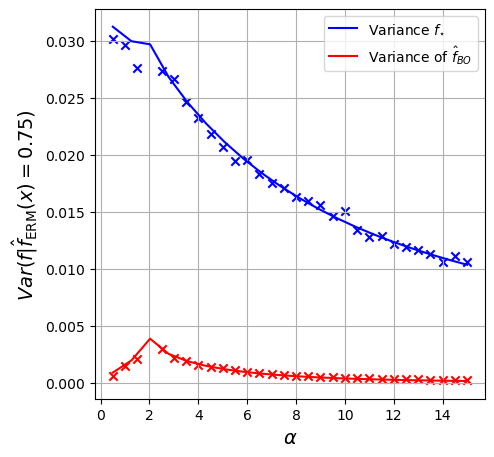

In [ ]:
# plot the variance of the the teacher for lambda_error and lambda_loss

variance_teacher = [ gcmpyo3.utility.conditional_variance_probit(o.m, o.q, sigma_0**2, 1.0, utility.sigmoid_inv(p)) for o in overlaps_lambda_0]
variance_bo = [ gcmpyo3.utility.conditional_variance_probit(o.m, o.q, sigma_0**2 + 1.0 - obo.q, obo.q, utility.sigmoid_inv(p)) for o, obo in zip(overlaps_lambda_0, overlaps_bo_lambda_0)]

plt.plot(alphas, variance_teacher, label='Variance $f_{\star}$', c='b')
plt.scatter(exp_alphas, teacher_variance, c='b', marker='x')
plt.plot(alphas, variance_bo, label='Variance of $\hat{f}_{BO}$', c='r')
plt.scatter(exp_alphas, bo_variance, c='r', marker='x')

plt.grid()
ax = plt.gca()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.xlabel('$\\alpha$')
plt.ylabel('$Var(f | \hat{f}_{\\rm ERM}(x) = 0.75)$')
plt.legend()

# do a square plot
plt.tight_layout()
plt.savefig('conditional_variance.pdf')